In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error, make_scorer
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
%matplotlib inline

# Part 1
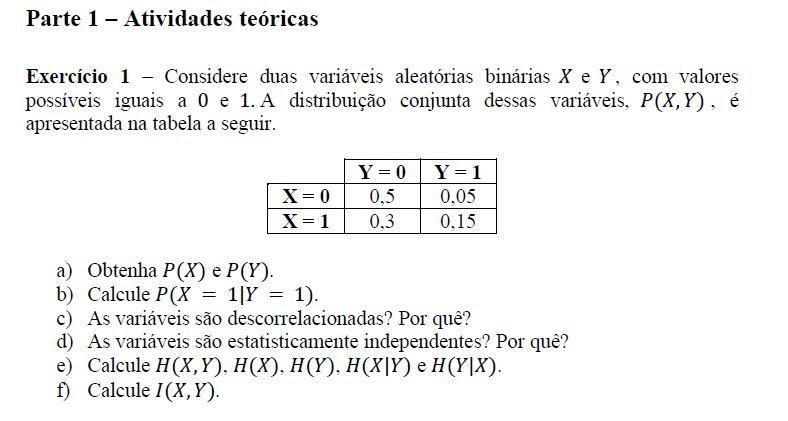

### a)
$P(X) = 0.45$

### b)
$P(X=1|Y=1) = 0.15$

### c)
As variáveis são descorrelacionadas se $cov(X,Y)=E[(X-\mu_X)(Y-\mu_Y)]=0$

Neste caso temos:

$\mu_X = 0.55*0 + 1*0.45 = 0.45$ 

$\mu_Y = 0.8*0 + 1*0.2 = 0.2$


Entao 
$cov(X, Y) = E[XY - \mu_X*Y - \mu_Y*X + \mu_Y*\mu_X] = E[XY] - \mu_XE[Y] - \mu_YE[X] + \mu_Y*\mu_X = $ 
$E[XY] - 0.225$

Então precisamos de $E[XY]$. Se criarmos uma nova variável aleatória M=XY, as possibilidades são:

|     | Y=0 | Y=1 |
|-----|-----|-----|
| X=0 | K=0   | K=0   |
| X=1 | K=0   | K=1   |

Assim, $E[XY] = E[K] = 0*(0.5 + 0.05 + 0.03) + 1*0.15 = 0.15$.

Portanto $cov(X, Y) = 0.15 - 0.225 = - 0.075 \neq 0$, e as variáveis não são descorrelacionadas.

### d)
Uma condição suficiente para dizer se duas variáveis aleatórias são independentes é se $P(XY)=P(X)P(Y)$.
Temos que $P(XY)=0.15 \neq P(X)P(Y) = 0.45 * 0.2 = 0.025$, portanto elas não são independentes.

### e)

$H(X) = -\sum_xp(x)log_2(p(x))$

$H(X, Y) = -\sum_x\sum_yp(x, y)log_2(p(x, y))$

$H(X|Y) = -\sum_x\sum_yp(x, y)log_2(p(x|y))$

$H(X, Y) = H(X) + H(Y|X) = H(Y) + H(X|Y)$


com $p(x) = P(X=x).

Então:

H(X) = 0.9928

H(Y) = 0.7219

H(X, Y) = 1.6477

H(X|Y) = 0.9258

H(Y|X) = 0.6550

### f)

I(X, Y) = 0.06697

# Part 2

## Visualizing the data

Our data is a time series that corresponds to the number of observed sunspots, every month, from 1749 to 2019, and our goal is to predict the future number of sunspots using only historical data.

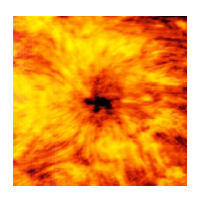

The methods we will be using are:
    * A Linear Regression that takes past values as inputs, i.e, an auto-regression;
    * Another auto regression, but the past values are first projected to another random dimension, and then we take their hyperbolic tangent value. This is a Extreme Learning Machine technique.

In [2]:
data = pd.read_csv("monthly-sunspots.csv", index_col=0)
get_index = lambda x: lambda date: int(date.split("-")[x])
data.rename(columns={"Monthly Mean Total Sunspot Number": "sunspots"}, inplace=True)
data["Year"] = data.Date.apply(get_index(0))
data["Month"] = data.Date.apply(get_index(1))
data["Day"] = data.Date.apply(get_index(2))
data.index = pd.date_range(start="31-1-1749", freq="1M", periods=len(data))
data.head(3)

,Date,sunspots,Year,Month,Day
1749-01-31,1749-01-31,96.7,1749,1,31
1749-02-28,1749-02-28,104.3,1749,2,28
1749-03-31,1749-03-31,116.7,1749,3,31


Statistical information:

In [3]:
data.sunspots.describe()

count    3252.000000
mean       82.070695
std        67.864736
min         0.000000
25%        24.200000
50%        67.750000
75%       122.700000
max       398.200000
Name: sunspots, dtype: float64

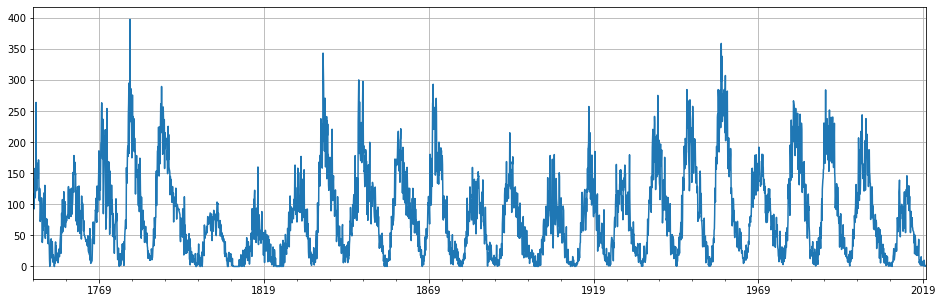

In [4]:
plt.figure(figsize=(16, 5))
data.sunspots.plot()
plt.grid()

### Creating train and test splits
The training data will be all the data up to 2010, and the testing data will be the data starting from 2010.

In [5]:
train_split = data.query("Year < 2010").sunspots.values.reshape(-1, 1)
test_split = data.query("Year >= 2010").sunspots.values.reshape(-1, 1)
print("Train:", len(train_split), "samples.")
print("Test:", len(test_split), "samples.")

Train: 3132 samples.
Test: 120 samples.


<!-- Temos 3132 amostras, então contanto que K seja menor que 3131 não precisaremos usar o Lagrangiano e poderemos utilizar mínimos quadrados. -->
We have 3132 training samples. Since K + 1 is less than 3132 we won't need to use the Lagrangian and it will be possible to use the least squares method. In the first K samples where we don't have the past K values needed for a complete feature vector, the missing values will be substituted by the mean value of the train dataset in the inference phase, but the model will not be trained with them, i.e, the first K-1 samples will not be used for training. Since we will also use a 5 fold cross validation, we need a K that satisfies $K + 1 < (3132 - K)/5 => K < 521$.

## Ex. 1

In [6]:
MSE = make_scorer(mean_squared_error)

class AutoregressiveEstimator(BaseEstimator):
    def __init__(self, K=1, use_only_existing=True):
        self.K = K
        self.use_only_existing = use_only_existing
        self.mean = 0
        
    def get_params(self, deep=None):
        return {
            "K": self.K
        }
    
    def set_params(self, **params):
        self.K = params.get("K", self.K)
        return self
    
    def create_features(self, x, is_inference=False):
        x = x.flatten()
        # Create placeholder
        x_ = np.ones((len(x), self.K)) * self.mean
        # Take past values of x
        for i in range(1, self.K + 1):
            x_[i:, i - 1] = x[:-i]
        # Use only past values
        if self.use_only_existing and not is_inference:
            x_ = x_[self.K:]
        # Bias input
        x = self.concat_bias_column(x_)
        return x
    
    def concat_bias_column(self, x):
        bias = np.ones((len(x), 1))
        x = np.concatenate([bias, x], axis=1)
        return x
    
    def create_labels(self, x, is_inference=False):
        if self.use_only_existing and not is_inference:
            return x[self.K:]
        return x
    
    def fit(self, x, y=None):
        self.mean = x.mean()
        y = self.create_labels(x)
        x = self.create_features(x)
        rank = np.linalg.matrix_rank(x[:, 1:])
        
        # Check the rank to make sure that x.T*x is invertible
        assert rank == self.K, f"Rank is {rank}, less than K"
        A = np.linalg.inv(np.matmul(x.T, x))
        B = np.matmul(x.T, y)
        self.W = np.matmul(A, B)
        return self
    
    def score(self, x, y=None):
        # If we input X[n] = [x[n], x[n+1] ... x[n+N]] the model wil predict X'[N+1] = [x'[n+1], x[n+2] ... x'[n+N+1]]
        # So, to calculate the RMSE with we need to ignore the first value from the labels (x[n]) and
        # The last value from the prediction (x'[n+N+1])
        y = self.create_labels(x, is_inference=True)[1:]
        prediction = self.predict(x)[:-1]
        # Using the RMSE function as a scoring function (minimizing -1 times the RMSE equals minimizing the RMSE)
        return - mean_squared_error(y, prediction, squared=False)
        
    def predict(self, x):
        x = self.create_features(x, is_inference=True)
        return np.matmul(x, self.W)


Plotting the past values used as features, and the labels (current value of the time series).

In [7]:
model = AutoregressiveEstimator(K=20, use_only_existing=True)
model.fit(train_split)
model.predict(train_split).shape, model.score(train_split)

((3132, 1), -28.482844048086367)

Features used
 [[  1.  116.7 104.3  96.7]
 [  1.   92.8 116.7 104.3]
 [  1.  141.7  92.8 116.7]
 [  1.  139.2 141.7  92.8]
 [  1.  158.  139.2 141.7]
 [  1.  110.5 158.  139.2]
 [  1.  126.5 110.5 158. ]
 [  1.  125.8 126.5 110.5]
 [  1.  264.3 125.8 126.5]
 [  1.  142.  264.3 125.8]]
Labels used
 [[ 92.8]
 [141.7]
 [139.2]
 [158. ]
 [110.5]
 [126.5]
 [125.8]
 [264.3]
 [142. ]
 [122.2]]


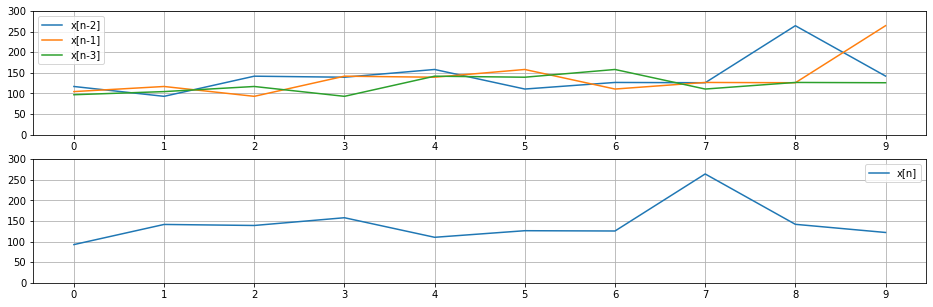

In [8]:
model = AutoregressiveEstimator(K=3, use_only_existing=True)
features = model.create_features(train_split)[:10]
labels =  model.create_labels(train_split)[:10]
print("Features used\n", features)
print("Labels used\n", labels)

_, axes = plt.subplots(2, 1, figsize=(16, 5))
axes[0].plot(features[:, 1], label="x[n-2]")
axes[0].plot(features[:, 2], label="x[n-1]")
axes[0].plot(features[:, 3], label="x[n-3]")
axes[1].plot(labels, label="x[n]")
for ax in axes:
    ax.legend()
    ax.set_xticks(range(10))
    ax.grid()
    ax.set_ylim([0, 300])

### Running the grid search
Searching for $1 <= K <= 24$

In [9]:
model = AutoregressiveEstimator(K=21, use_only_existing=True)
model.fit(train_split)
model.predict(train_split).shape, model.score(train_split)

((3132, 1), -28.477643698843675)

In [10]:
K_range = range(1, 24 + 1)
grid_search = GridSearchCV(
    AutoregressiveEstimator(use_only_existing=True),
    param_grid={"K": K_range},
    cv=5
)
grid_search.fit(train_split, y=None)

GridSearchCV(cv=5, error_score=nan, estimator=AutoregressiveEstimator(K=1),
             iid='deprecated', n_jobs=None, param_grid={'K': range(1, 25)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

Best RMSE: 29.004383095920172
Best K: 21


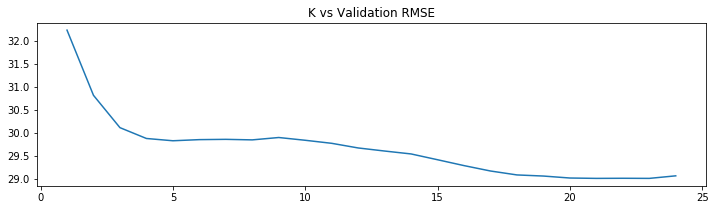

In [11]:
K_values = [params["K"] for params in grid_search.cv_results_["params"]]
plt.figure(figsize=(12, 3))
plt.title("K vs Validation RMSE")
plt.plot(K_values, -grid_search.cv_results_["mean_test_score"])
print("Best RMSE:", -grid_search.best_score_)
print("Best K:", grid_search.best_params_["K"])

Best model test RMSE: 29.004383095920172
Best K: 21


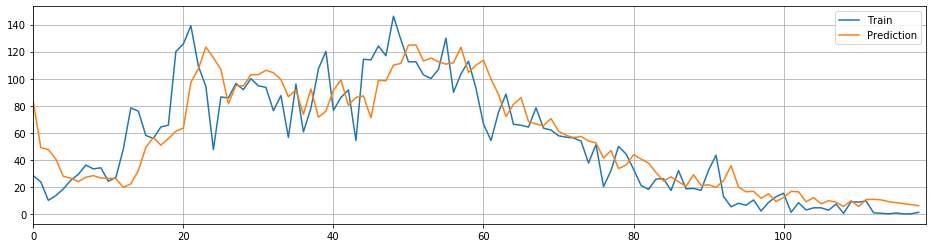

In [12]:
model = grid_search.best_estimator_
K = grid_search.best_params_["K"]
N = len(test_split) - 1

best_rmse = - grid_search.best_score_
plt.figure(figsize=(16, 4))
# Removing the first test_sample since the first prediction of the test_split will be for x[1] and not x[0]
plt.plot(test_split[1:N+1], label="Train")
plt.plot(range(N), model.predict(test_split)[:N], label="Prediction")
plt.xlim([0, N])
plt.grid()
plt.legend()
print("Best model test RMSE:", best_rmse)
print("Best K:", K)

## Ex. 2

Here we will use the same training protocol as we used in Part 1 (we won't train with the first K values).
Data is scaled between $\frac{-1.5}{K}$ and $\frac{1.5}{K}$ because in the matrix multiplication:

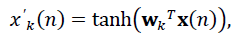

This makes the values of $x \in w_k^Tx(n)$ be bounded between $\frac{-1.5}{K} * K = -1.5 \leq x \leq 1.5 =\frac{1.5}{K} * K$, so the value of the elements in $tanh(w_k^Tx(n))$ will be bounded between $-0.9051$ and $0.9051$, and the $tanh$ function will not "saturate", as the figure shows:

In [13]:
from sklearn.metrics import mean_squared_error, make_scorer
from functools import partial

class AutoregressiveELMRidgeEstimator(AutoregressiveEstimator):
    def __init__(self, K=20, T=20, alpha=1e-3, use_only_existing=False, seed=4, scaler=None):
        self.K = K
        self.T = T
        self.use_only_existing = use_only_existing
        self.scaler = scaler
        self.seed = seed
        self.alpha = alpha
        self.verbose = False
        self.mean = 0

    def get_params(self, deep=None):
        return {
            "K": self.K,
            "T": self.T,
            "alpha": self.alpha,
            "scaler": self.scaler
        }
    
    def set_params(self, **params):
        self.K = params.get("K", self.K)
        self.T = params.get("T", self.T)
        self.alpha = params.get("alpha", self.alpha)
        self.scaler = params.get("scaler", self.scaler)
        return self
    
    def create_elm_weights(self):
        np.random.seed(self.seed)
        # Transformation weights are initialized with a random uniform distribution with a=-1 and b=1
        self.ELM_weights = np.random.uniform(low=-1, high=1, size=(self.T, self.K))
        
    def create_labels(self, x, is_inference=False):
        if self.scaler:
            x = self.scaler.transform(x)
        if self.use_only_existing and not is_inference:
            return x[self.K:]
        return x
    
    def create_features(self, x, is_inference=False):
        if self.scaler:
            x = self.scaler.transform(x)
        x = x.flatten()
        # Create placeholder
        x_ = np.ones((len(x), self.K)) * self.mean
        # Take K past values of x
        for i in range(1, self.K + 1):
            x_[i:, i - 1] = x[:-i]
        # Use only past values
        if self.use_only_existing and not is_inference:
            x_ = x_[self.K:]

        # Project them into random feature space
        if self.T:
            x_ = np.matmul(self.ELM_weights, x_.T).T
            assert (x_.max() < 1.5) and (x_.min() > -1.5), str(x_.shape) + "Max: {} | Min: {}".format(x_.max(), x_.min())
            x_ = np.tanh(x_)
        # Bias input
        # x = self.concat_bias_column(x_)
        if self.verbose:
            print("CREATED", x_.max(), x_.min())
        return x_
    
    def identity_prime(self):
        size = self.T if self.T else self.K
        ip = np.identity(size)
        ip[0, 0] = 0
        return ip
    
    def fit(self, x, y=None):
        self.create_elm_weights()
        if self.scaler is not None:
            self.scaler.fit(x.reshape(-1, 1))
            self.mean = self.scaler.transform(x.reshape(-1, 1)).mean()
        else:
            self.mean = x.mean()
        
        y = self.create_labels(x)
        x = self.create_features(x)
        A = np.linalg.inv(np.matmul(x.T, x) + self.alpha*self.identity_prime())
        B = np.matmul(x.T, y)
        self.W = np.matmul(A, B)
        return self
    
    def score(self, x, y=None):
        y = self.scaler.inverse_transform(self.create_labels(x, is_inference=True))[1:]
        pred = self.predict(x)[:-1]
        return - mean_squared_error(y, pred, squared=False)
        
    def set_verbose(self):
        self.verbose=True
    
    def predict(self, x):
        x = self.create_features(x, is_inference=True)
        pred = np.matmul(x, self.W)
        if self.scaler:
            pred = self.scaler.inverse_transform(pred)
        return pred

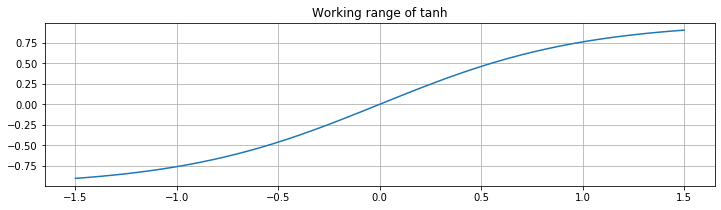

In [14]:
x = np.linspace(-1.5, 1.5)
y = np.tanh(x)
plt.figure(figsize=(12, 3))
plt.plot(x, y)
plt.title("Working range of tanh")
plt.grid()

We will use a 5-fold cross validation scheme, and the values for alpha will vary from $10^{-10}$ to $10^{10}$, in a geometric progression, so we can cover a big range of values.

In [15]:
from sklearn.preprocessing import MinMaxScaler
import tqdm

results = []

# K is fixed in 8
K = 8

T_vector = np.arange(1, 100 + 1, 1)

scaler = MinMaxScaler(feature_range=(-1.5/K, 1.5/K))

# For each T from 1 to 100...
for t in tqdm.tqdm(T_vector):

    grid_search = GridSearchCV(
        AutoregressiveELMRidgeEstimator(
            scaler=scaler,
            seed=111,
            use_only_existing=True
        ),
        param_grid={
            "K": [K],
            "T": [t],
            "alpha": np.logspace(-10, 10, 50)
        },
        cv=5,
        verbose=0,
        n_jobs=3,
        refit=True
    )
    grid_search.fit(train_split, y=None)
    
    # Saving the results
    result = {
        "score": grid_search.best_score_,
        "alpha": grid_search.best_params_["alpha"],
        "T": t,
        "K": K,
        "model": grid_search.best_estimator_
    }
    plt.show()
    results.append(result)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:32<00:00,  1.52s/it]


Best RMSE: 29.81653207578364


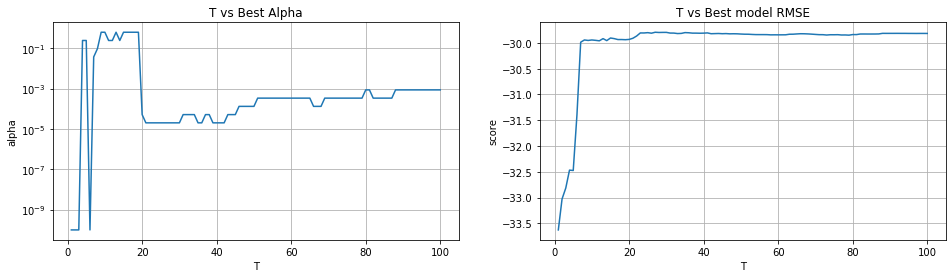

In [16]:
import pandas as pd
import seaborn as sns

results_dataframe = pd.DataFrame(results)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
sns.lineplot(data=results_dataframe, x="T", y="alpha", ax=ax1)
ax1.set_yscale("log")
sns.lineplot(data=results_dataframe, x="T", y="score", ax=ax2)

ax1.set_title("T vs Best Alpha")
ax1.grid()

ax2.set_title("T vs Best model RMSE")
ax2.grid()

print("Best RMSE:", -grid_search.best_score_)

In [17]:
results_dataframe.sort_values(by="score", ascending=False).head()

,score,alpha,T,K,model
26,-29.793234,0.00002,27,8,"AutoregressiveELMRidgeEstimator(K=8, T=27, alp..."
29,-29.795827,0.00002,30,8,"AutoregressiveELMRidgeEstimator(K=8, T=30, alp..."
28,-29.796318,0.00002,29,8,"AutoregressiveELMRidgeEstimator(K=8, T=29, alp..."
27,-29.797776,0.00002,28,8,"AutoregressiveELMRidgeEstimator(K=8, T=28, alp..."
34,-29.800194,0.00002,35,8,"AutoregressiveELMRidgeEstimator(K=8, T=35, alp..."


In [18]:
best_val_score, best_alpha, best_T, best_K, best_model = results_dataframe.sort_values(by="score", ascending=False).head(1).values.T.flatten()

Best model test RMSE: 20.38871226955621
K: 8
Best T: 27
Best alpha: 2.0235896477251556e-05


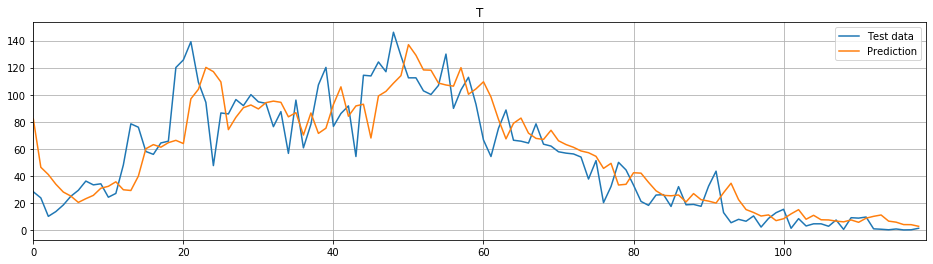

In [19]:
test_rmse = best_model.score(test_split)
print("Best model test RMSE:", -test_rmse)

plt.figure(figsize=(16, 4))

# Removing the first test_sample since the first prediction of the test_split will be for x[1] and not x[0]
plt.plot(test_split[1:], label="Test data")
plt.plot(range(N), best_model.predict(test_split)[:-1], label="Prediction")
plt.title("T")
plt.xlim([0, N])
plt.grid()
plt.legend()

print("K:", best_K)
print("Best T:", best_T)
print("Best alpha:", best_alpha)
